# SQL Database agent

In this cookbook, we will walk through how to build an agent that can answer questions about a SQL database. 

We'll also show how to evaluate it in 3 different ways. See our conceptual guide and agent tutorial for added context:
  
* [Conceptual guide for evaluations](https://docs.smith.langchain.com/concepts/evaluation)
* [Guide for agent evaluations](https://docs.smith.langchain.com/tutorials/Developers/agents)

## Set up environment

We'll set up our environment variables for OpenAI, and optionally, to enable tracing with [LangSmith](https://smith.langchain.com).

In [ ]:
%pip install --upgrade --quiet langchain langsmith langchain-community langchain-experimental langgraph

In [12]:
import os

os.environ["OPENAI_API_KEY"] = "sk-..."
os.environ["LANGSMITH_API_KEY"] = "lsv2_pt_..."
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "sql-agent"

In [1]:
import os
os.environ["LANGSMITH_API_KEY"] = "xxx"

## Configure the database

We will be creating a SQLite database for this tutorial. SQLite is a lightweight database that is easy to set up and use. We will be loading the `chinook` database, which is a sample database that represents a digital media store.
Find more information about the database [here](https://www.sqlitetutorial.net/sqlite-sample-database/).

For convenience, we have hosted the database (`Chinook.db`) on a public GCS bucket.

In [ ]:
import requests
url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

We will use a handy SQL database wrapper available in the `langchain_community` package to interact with the database. The wrapper provides a simple interface to execute SQL queries and fetch results. We will also use the `langchain_openai` package to interact with the OpenAI API for language models later in the tutorial.

In [23]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

## SQL Agent

We'll use a [LangGraph agent](https://www.langchain.com/agents) with access to a set of tools for working with SQL:

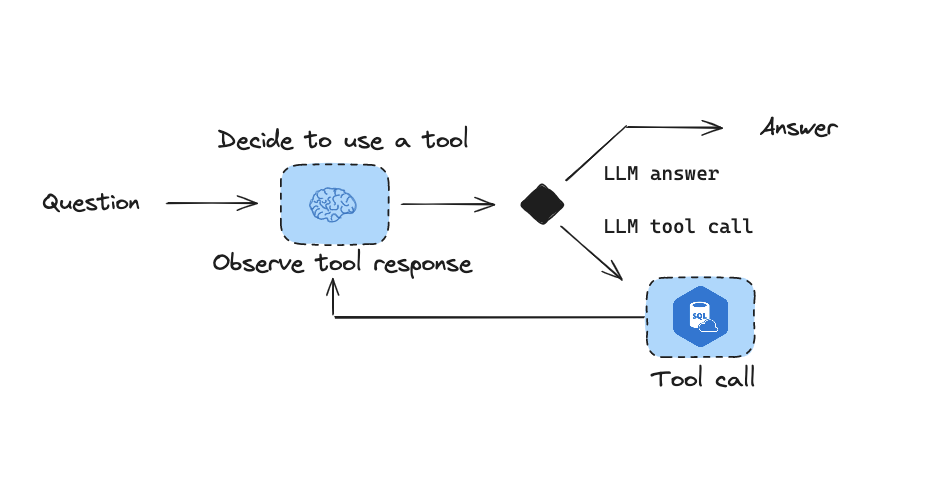

### LLM

In [106]:
from langchain_openai import ChatOpenAI
from langchain_fireworks import ChatFireworks

### gpt4o
llm=ChatOpenAI(model="gpt-4o",temperature=0)
experiment_prefix="sql-agent-gpt4o"
metadata = "Chinook, gpt-4o base-case-agent"

### Fireworks
llm=ChatFireworks(model="accounts/fireworks/models/firefunction-v2",temperature=0)
experiment_prefix="sql-agent-fireworks" 
metadata = "Chinook, fireworks base-case-agent"


### Tools
 
We'll use [SQL toolkit](https://python.langchain.com/v0.2/docs/tutorials/sql_qa/#agents) as well as some custom tools to check the query before executing it and check the query result from the database to confirm it is not empty or irrelevant to the question.

In [107]:
import json


from langchain_community.agent_toolkits import SQLDatabaseToolkit

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, MessageGraph
from langgraph.prebuilt.tool_node import ToolNode
from langchain_core.messages import AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import tool

# SQL toolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

# Query checking
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

Execute the correct query with the appropriate tool."""
query_check_prompt = ChatPromptTemplate.from_messages([("system", query_check_system),("user", "{query}")])
query_check = query_check_prompt | llm

@tool
def check_query_tool(query: str) -> str:
    """
    Use this tool to double check if your query is correct before executing it.
    """
    return query_check.invoke({"query": query}).content

# Query result checking
query_result_check_system = """You are grading the result of a SQL query from a DB. 
- Check that the result is not empty.
- If it is empty, instruct the system to re-try!"""
query_result_check_prompt = ChatPromptTemplate.from_messages([("system", query_result_check_system),("user", "{query_result}")])
query_result_check = query_result_check_prompt | llm

@tool
def check_result(query_result: str) -> str:
    """
    Use this tool to check the query result from the database to confirm it is not empty and is relevant.
    """
    return query_result_check.invoke({"query_result": query_result}).content

tools.append(check_query_tool)
tools.append(check_result)

### State

In [108]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### SQL Assistant

Here, we lay out the instructions of our agent, building on this [prompt](https://python.langchain.com/v0.2/docs/tutorials/sql_qa/#agents).

In [109]:
from langchain_core.runnables import Runnable, RunnableConfig

# Assistant
class Assistant:
    
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            # Append to state
            state = {**state}
            # Invoke the tool-calling LLM
            result = self.runnable.invoke(state)
            # If it is a tool call -> response is valid
            # If it has meaninful text -> response is valid
            # Otherwise, we re-prompt it b/c response is not meaninful
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

# Assistant runnable
query_gen_system = """
ROLE:
You are an agent designed to interact with a SQL database. You have access to tools for interacting with the database.
GOAL:
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
INSTRUCTIONS:
- Only use the below tools for the following operations.
- Only use the information returned by the below tools to construct your final answer.
- To start you should ALWAYS look at the tables in the database to see what you can query. Do NOT skip this step.
- Then you should query the schema of the most relevant tables.
- Write your query based upon the schema of the tables. You MUST double check your query before executing it. 
- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
- You can order the results by a relevant column to return the most interesting examples in the database.
- Never query for all the columns from a specific table, only ask for the relevant columns given the question.
- If you get an error while executing a query, rewrite the query and try again.
- If the query returns a result, use check_result tool to check the query result.
- If the query result result is empty, think about the table schema, rewrite the query, and try again.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""

query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system),("placeholder", "{messages}")])
assistant_runnable = query_gen_prompt | llm.bind_tools(tools)

### Graph Utilities

We will define a few utility functions to help us with the agent implementation. Specifically, we will wrap a ToolNode with a fallback to handle errors and surface them to the agent.

In [110]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

### Graph

We will then define the workflow for the agent.

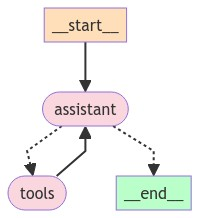

In [111]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition, 
    # "tools" calls one of our tools. END causes the graph to terminate (and respond to the user)
    {"tools": "tools", END: END},
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### Test

In [8]:
questions = ["Which country's customers spent the most? And how much did they spend?",
             "How many albums does the artist Led Zeppelin have?",
             "What was the most purchased track of 2017?",
             "Which sales agent made the most in sales in 2009?"]

In [ ]:
## Invoke

import uuid 
_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

msg = {"messages": ("user", questions[0])}
messages = graph.invoke(msg,config)
messages['messages'][-1].content

In [ ]:
## Stream

import uuid 
_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[0])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

### Eval
 
[Agent evaluation](https://docs.smith.langchain.com/concepts/evaluation#agents) can focus on 3 things:

* `Response`: The inputs are a prompt and a list of tools. The output is the agent response.
* `Single tool`: As before, the inputs are a prompt and a list of tools. The output the tool call.
* `Trajectory`: As before, the inputs are a prompt and a list of tools. The output is the list of tool calls

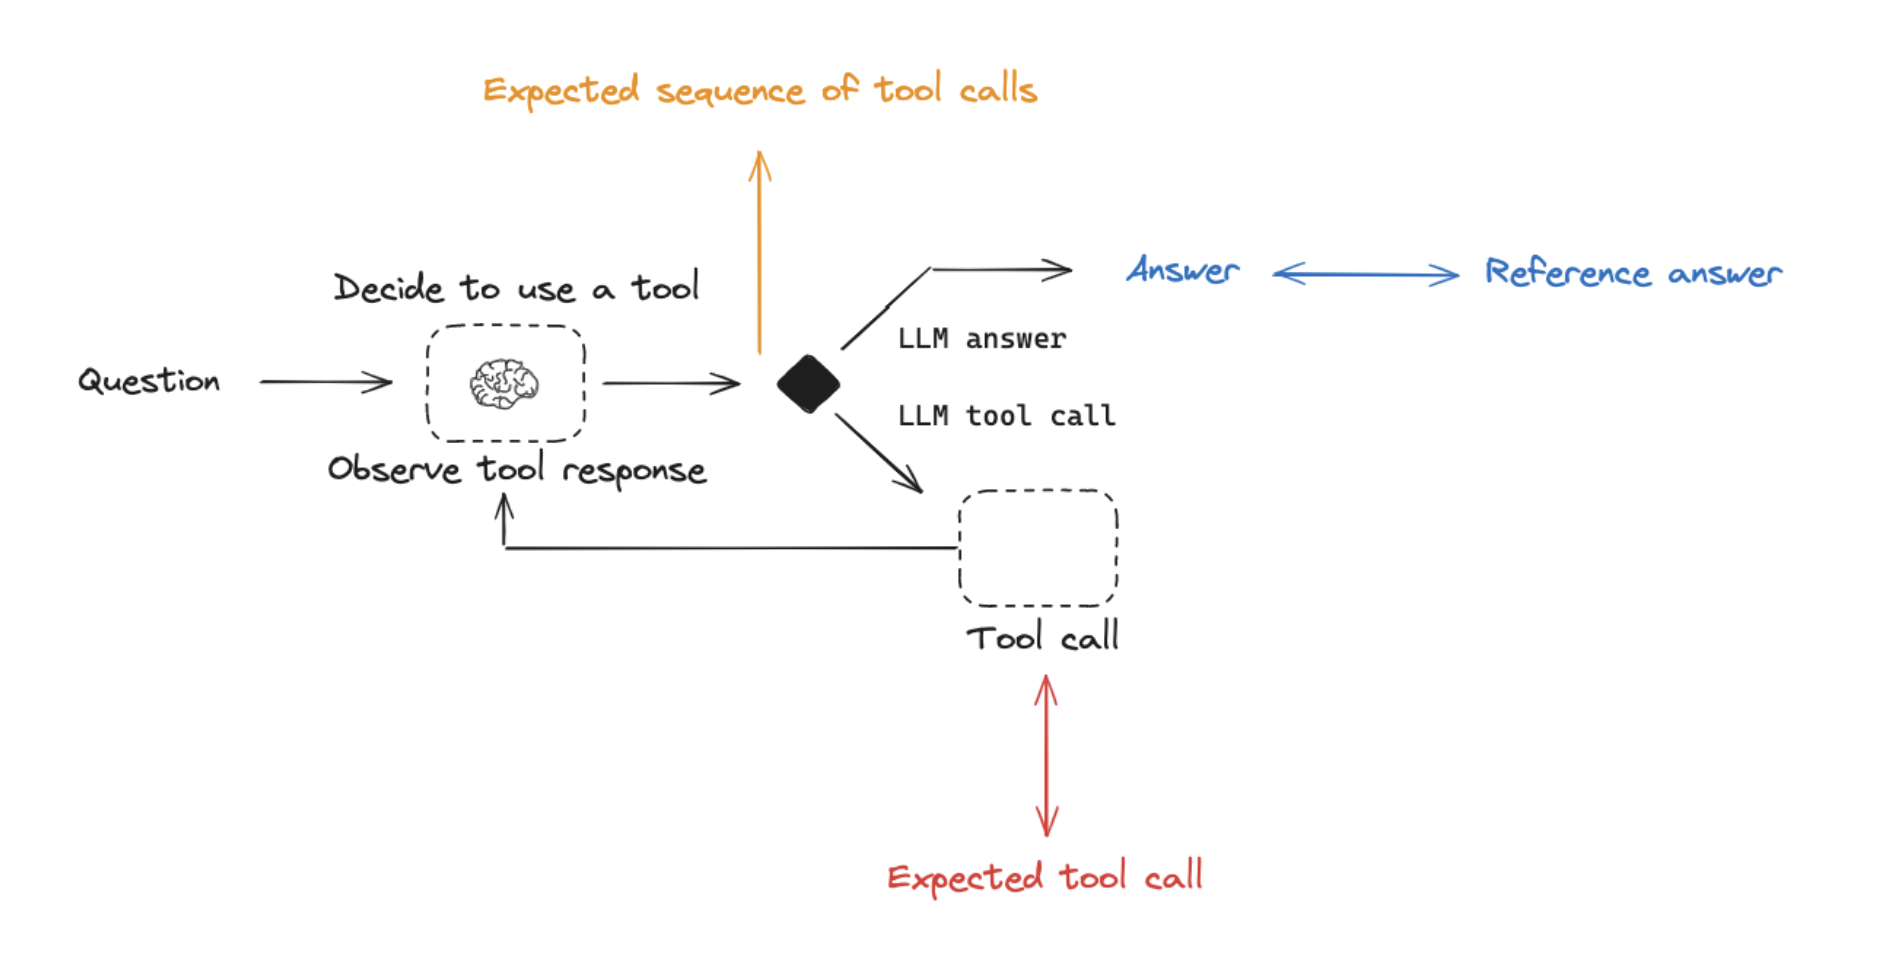

#### Response

We can evaluate how well an agent does overall on a task. This basically involves treating the agent as a black box and just evaluating whether it gets the job done or not.


`Dataset`

First, create a dataset that evaluates end-to-end performance of the agent on our eval set.

In [31]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    ("Which country's customers spent the most? And how much did they spend?", "The country whose customers spent the most is the USA, with a total expenditure of $523.06"),
    ("What was the most purchased track of 2013?", "The most purchased track of 2013 was Hot Girl."),
    ("How many albums does the artist Led Zeppelin have?","Led Zeppelin has 14 albums"),
    ("What is the total price for the album “Big Ones”?","The total price for the album 'Big Ones' is 14.85"),
    ("Which sales agent made the most in sales in 2009?", "Steve Johnson made the most sales in 2009"),
]

dataset_name = "SQL Agent Response"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

`Run chain`

In [102]:
import uuid 
_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

def predict_sql_agent_answer(example: dict):
    """Use this for answer evaluation"""
    msg = {"messages": ("user", example["input"])}
    messages = graph.invoke(msg, config)
    return {"response": messages['messages'][-1].content}

`Evaluator`

This can [follow what we do for RAG](https://docs.smith.langchain.com/tutorials/Developers/rag) where we compare the generated answer with the reference answer.

Log [to our dataset](https://smith.langchain.com/public/20808486-67c3-4e30-920b-6d49d6f2b6b8/d).

In [112]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = prompt = hub.pull("langchain-ai/rag-answer-vs-reference")

def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get question, ground truth answer, chain answer
    input_question = example.inputs["input"]    
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke({"question": input_question,
                                  "correct_answer": reference,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_v_reference_score", "score": score}

`Create evaluation`

In [113]:
from langsmith.evaluation import evaluate

dataset_name = "SQL Agent Response"
experiment_results = evaluate(
    predict_sql_agent_answer,
    data=dataset_name,
    evaluators=[answer_evaluator],
    num_repetitions=3,
    experiment_prefix=experiment_prefix + "-response-v-reference",
    metadata={"version": metadata},
)

View the evaluation results for experiment: 'sql-agent-fireworks-response-v-reference-b92cc255' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/c6caf3a4-a975-4a14-bb1c-ae98bf06e359/compare?selectedSessions=ab1300c0-a46e-4e20-b289-a6fe4326db9e




0it [00:00, ?it/s]

#### Single tool

Agents generally make multiple actions. While it is useful to evaluate them end-to-end, it can also be useful to evaluate the individual actions. This generally involves evaluating a single step of the agent - the LLM call where it decides what to do.

We can check a specific tool call using [custom evaluators](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#use-custom-evaluators). We'll run these [on our dataset](https://smith.langchain.com/public/20808486-67c3-4e30-920b-6d49d6f2b6b8/d). Here, we'll use a custom evaluator. We define an `expected_tool_call` for the input questions in our dataset. The `expected_tool_call` is fixed for every question, because we always expect the agent to run `sql_db_list_tables`. But this can be modified easily for your case.

In [73]:
def predict_assistant(example: dict):
    """Invoke assistant for single tool call evaluation"""
    msg = [ ("user", example["input"]) ]
    result = assistant_runnable.invoke({"messages":msg})
    return {"response": result}

In [74]:
from langsmith.schemas import Example, Run

def check_specific_tool_call(root_run: Run, example: Example) -> dict:
    """
    Check if the first tool call in the response matches the expected tool call.
    """

    # Exepected tool call
    expected_tool_call = 'sql_db_list_tables'

    # Run
    response = root_run.outputs["response"]

    # Get tool call
    try:
        tool_call = getattr(response, 'tool_calls', [])[0]['name']

    except (IndexError, KeyError):
        tool_call = None

    score = 1 if tool_call == expected_tool_call else 0
    return {"score": score, "key": "single_tool_call"}

In [75]:
experiment_results = evaluate(
    predict_assistant,
    data=dataset_name,
    evaluators=[check_specific_tool_call],
    experiment_prefix=experiment_prefix + "-single-tool",
    num_repetitions=3,
    metadata={"version": metadata},
)

View the evaluation results for experiment: 'sql-agent-fireworks-single-tool-27adb661' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/c6caf3a4-a975-4a14-bb1c-ae98bf06e359/compare?selectedSessions=33d064e1-39ad-452d-b939-382a4cefa194




0it [00:00, ?it/s]

#### Trajectory

We can check a trajectory of tool calls using [custom evaluators](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#use-custom-evaluators). We'll run these [on our dataset](https://smith.langchain.com/public/20808486-67c3-4e30-920b-6d49d6f2b6b8/d). Here, we'll also use a custom evaluator. We define an `expected` trajectory that the agent will take for the input questions in our dataset. We can also customize this, checking if all of the tool calls are called in any order or if the exact order of the expected tool calls is met.

In [103]:
def predict_sql_agent_messages(example: dict):
    """Use this for answer evaluation"""
    msg = {"messages": ("user", example["input"])}
    messages = graph.invoke(msg, config)
    return {"response": messages}

In [104]:
def find_tool_calls(messages):
    """  
    Find all tool calls in the messages returned 
    """
    tool_calls = [tc['name'] for m in messages['messages'] for tc in getattr(m, 'tool_calls', [])]
    return tool_calls

def contains_all_tool_calls_any_order(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in any order.
    """
    expected = ['sql_db_list_tables', 'sql_db_schema', 'sql_db_query_checker', 'sql_db_query', 'check_result']
    messages = root_run.outputs["response"]
    tool_calls = find_tool_calls(messages)
    # Optionally, log the tool calls - 
    #print("Here are my tool calls:")
    #print(tool_calls)
    if set(expected) <= set(tool_calls):
        score = 1
    else: 
        score = 0
    return {"score": int(score), "key": "multi_tool_call_any_order"}

def contains_all_tool_calls_in_order(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order.
    """
    messages = root_run.outputs["response"]
    tool_calls = find_tool_calls(messages)
    # Optionally, log the tool calls - 
    #print("Here are my tool calls:")
    #print(tool_calls)
    it = iter(tool_calls)
    expected = ['sql_db_list_tables', 'sql_db_schema', 'sql_db_query_checker', 'sql_db_query', 'check_result']
    if all(elem in it for elem in expected):
        score = 1
    else: 
        score = 0
    return {"score": int(score), "key": "multi_tool_call_in_order"}

def contains_all_tool_calls_in_order_exact_match(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    expected = ['sql_db_list_tables', 'sql_db_schema', 'sql_db_query_checker', 'sql_db_query', 'check_result']
    messages = root_run.outputs["response"]
    tool_calls = find_tool_calls(messages)
    # Optionally, log the tool calls - 
    #print("Here are my tool calls:")
    #print(tool_calls)
    if tool_calls == expected:
        score = 1
    else:
        score = 0
    
    return {"score": int(score), "key": "multi_tool_call_in_exact_order"}

In [105]:
experiment_results = evaluate(
    predict_sql_agent_messages,
    data=dataset_name,
    evaluators=[contains_all_tool_calls_any_order,contains_all_tool_calls_in_order,contains_all_tool_calls_in_order_exact_match],
    experiment_prefix=experiment_prefix + "-trajectory",
    num_repetitions=3,
    metadata={"version": metadata},
)

View the evaluation results for experiment: 'sql-agent-gpt4o-trajectory-8673e1b5' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/c6caf3a4-a975-4a14-bb1c-ae98bf06e359/compare?selectedSessions=695ded48-e449-4b68-87b3-926da929a5a1




0it [00:00, ?it/s]

You can see the results from the evaluations here:

* Similar end-to-end performance with response evaluation
* However, gpt4o fails to call `check_result` tool on the output

https://smith.langchain.com/public/20808486-67c3-4e30-920b-6d49d6f2b6b8/d